In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Téléchargement des fichiers

## Jeux de données de jouer au Tennis

In [272]:
tenis_df = pd.read_csv('./data/play_tennis.csv')

In [273]:
tenis_df.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


## Jeux de données des caractères manuscrits

In [274]:
path1 = "./data/traindat.txt"
path2 = "./data/Testdat.txt"

In [275]:
def read_sys_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 9:
                classes, m00, mu02, mu11, mu20, mu03, mu12, mu21, mu30 = str(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7]), float(parts[8])
                data.append((classes, m00, mu02, mu11, mu20, mu03, mu12, mu21, mu30))
    
    return pd.DataFrame(data, columns=["classes", "m00","mu02","mu11","mu20","mu03","mu12","mu21","mu30"])

In [276]:
train_data = read_sys_file(path1)
test_data = read_sys_file(path2)
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [277]:
all_data.head()

,classes,m00,mu02,mu11,mu20,mu03,mu12,mu21,mu30
0,a,119.0,1164.571429,-84.000000,2274.705882,-728.448980,-1026.235294,-308.016807,2446.878893
1,a,124.0,1205.870968,-30.129032,2439.120968,-703.298647,-1067.540583,-395.008325,2494.423127
2,a,123.0,1167.365854,-47.073171,2372.747967,-531.112433,-1078.021416,-452.984335,2438.033181
3,a,131.0,1288.229008,-13.320611,2523.648855,-480.553814,-1266.542218,-219.485170,2209.729619
4,a,133.0,1385.879699,-148.030075,2644.992481,-613.045395,-1565.516988,-251.322856,2869.338459


# Implémentation de K-Means

Pour implémenter K-Means, j'ai suivi les étapes suivantes:
- Choisir le nombre K de classes.
- Initialiser le centre de chaque classe avec un point de données choisi aléatoirement.
- Affecter chaque point de données à la classe dont le centre est le plus proche.
- Recalculer le centre (moyenne).

**Remarque:** La condition de convergence est la stabilité. Les centres ne varient pas de ε, qui peut être défini par l'utilisateur; initialement, il est de 0,0001.

In [278]:
def initialize_centroids(n_estimators, data):
    indices = np.random.choice(data.shape[0], size=n_estimators, replace=False)
    return data[indices]

In [279]:
def l2_norm(data, centroid):
    return np.linalg.norm(x=(data - centroid), ord=2)

In [280]:
def update_centroids(data, centroids, clusters):
    centroids_new = centroids.copy()
    for i in range(len(centroids_new)):
        subset = np.where(clusters==i)[0]
        centroids_new[i] = np.mean(data[subset], axis=0)
    return centroids_new

In [281]:
def calculate_inertia(data, clusters, centroids):
    inertia = 0.0
    for i in range(len(centroids)):
        subset = data[clusters == i]
        inertia += np.sum((subset - centroids[i]) ** 2)
    return inertia

In [282]:
def kmeans_implemented(data, n_estimators, eps=1e-4, print_=True):
    # convert data to numpy array
    data = np.asarray(data)
    # initialize centroids position
    centroids = initialize_centroids(n_estimators, data)
    
    # define a list that contains the predicted cluster
    clusters = np.zeros(data.shape[0])
    
    j = 0
    while True:
        for i in range(len(data)):
            # compute distances to each centroid
            distance = [l2_norm(data[i], centroid) for centroid in centroids]
            # assign point to the nearest cluster
            cluster = np.argmin(distance)
            clusters[i] = cluster

        new_centroids = update_centroids(data, centroids, clusters)
        
        if np.linalg.norm(centroids - new_centroids) < eps:
            break
        
        centroids = new_centroids
        j += 1
    
    if print_:
        print("nombre d'itérations", j)
    
    inertia = calculate_inertia(data, clusters, centroids)
    return centroids, inertia

In [283]:
def kmeans_predict(centroids, data):
    data = data.to_numpy()
    clusters = []
    for i in range(len(data)):
        # compute distances to each centroid
        distance = [l2_norm(data[i], centroid) for centroid in centroids]
        # assign point to the nearest cluster
        cluster = np.argmin(distance)
        # append the predicted cluster
        clusters.append(cluster)
    return clusters

# Jeux de données de jouer au Tennis

## Data Encoding

In [284]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

encoded_data = enc.fit_transform(tenis_df.drop('day', axis=1))

encoded_df = pd.DataFrame(data=encoded_data, columns=tenis_df.drop('day', axis=1).columns)

In [285]:
encoded_df.head()

,outlook,temp,humidity,wind,play
0,2.0,1.0,0.0,1.0,0.0
1,2.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0
3,1.0,2.0,0.0,1.0,1.0
4,1.0,0.0,1.0,1.0,1.0


## Kmeans

### Kmeans Sklearn

In [286]:
from sklearn.cluster import KMeans

tennis_features = encoded_df.drop(['play'], axis=1)

kmeans2 = KMeans(n_clusters=2, random_state=46).fit(tennis_features)
tennis_predicted = kmeans2.predict(tennis_features)

In [287]:
tennis_comparison = pd.DataFrame({
    'original_labels': encoded_df['play'].astype(int),
    'predicted_labels': tennis_predicted
})

In [288]:
tennis_comparison.head()

,original_labels,predicted_labels
0,0,0
1,0,0
2,1,1
3,1,1
4,1,0


**Remarque:** Je suppose que les 0 ne sont pas joués et que les 1 sont joués pour les données prédites par le modèle sklearn

In [289]:
from sklearn.metrics import precision_score

precision = precision_score(tennis_comparison['original_labels'], tennis_comparison['predicted_labels'])

print('la précision de modele est:', precision)

la précision de modele est: 0.75


### Kmeans Implementé

In [290]:
final_centroids, inertia_tennis = kmeans_implemented(data=tennis_features, n_estimators=2)

tennis_predicted2 = kmeans_predict(final_centroids, tennis_features)

nombre d'itérations 2


In [291]:
tennis_comparison['predicted_labels_implemented'] = tennis_predicted2

In [292]:
tennis_comparison.head()

,original_labels,predicted_labels,predicted_labels_implemented
0,0,0,0
1,0,0,0
2,1,1,1
3,1,1,0
4,1,0,1


In [293]:
precision2 = precision_score(tennis_comparison['original_labels'], tennis_comparison['predicted_labels_implemented'])
print('La précision du modèle implémenté est:', precision2)

La précision du modèle implémenté est: 0.8333333333333334


**Remarque:** j'ai remarqué que la précision change considérablement lorsque le point de départ varie, donc un algorithme capable de garantir une bonne initialisation des points peut surpasser le modèle proposé par sklearn.

## DBSCAN

In [294]:
from sklearn.cluster import DBSCAN

eps_values = [1, 2]
minPts = [2, 3]

tennis_comparison_dbscan = pd.DataFrame({
    'original_labels': encoded_df['play'].astype(int)
})

for eps in eps_values:
    for minPt in minPts:
        dbscan_model = DBSCAN(eps=eps, min_samples=minPt, metric="euclidean")
        dbscan_model.fit(tennis_features)
        
        predictions_dbscan = dbscan_model.labels_
        
        tennis_comparison_dbscan[f'predicted_eps{eps}_minPts{minPt}'] = predictions_dbscan

In [295]:
tennis_comparison_dbscan.head()

,original_labels,predicted_eps1_minPts2,predicted_eps1_minPts3,predicted_eps2_minPts2,predicted_eps2_minPts3
0,0,0,0,0,0
1,0,0,0,0,0
2,1,1,-1,0,0
3,1,0,0,0,0
4,1,2,1,0,0


**Remarque:** Pour l'évaluation des clusters prédits, je vais choisir les résultats du modèle avec eps = 1 et minPts = 3, car c'est le seul qui a donné deux clusters "play" ou "not play"

In [296]:
outliers_index = tennis_comparison_dbscan[tennis_comparison_dbscan['predicted_eps1_minPts3']==-1].index

In [297]:
tenis_df.iloc[outliers_index,:]

,day,outlook,temp,humidity,wind,play
2,D3,Overcast,Hot,High,Weak,Yes
10,D11,Sunny,Mild,Normal,Strong,Yes
12,D13,Overcast,Hot,Normal,Weak,Yes


On remarque que l'algorithme DBSCAN a attribué la valeur -1 aux jours 3, 10 et 12, ce qui signifie que ces jours sont considérés comme des bruits. En regardant de plus près, cela semble logique car ces données sont contradictoires avec les autres, ce qui explique pourquoi l'algorithme ne les a pas incluses dans un cluster.

# Jeux de données des caractères manuscrits

## Kmeans

In [298]:
mnist_features = all_data.drop(columns=['classes'])
mnist_features = (mnist_features - mnist_features.mean())/mnist_features.std()

inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mnist_features)
    inertia.append(kmeans.inertia_)


inertia_mnist_impl = []
for k in range(1, 25):
    final_centroids, inertia_mnist = kmeans_implemented(data=mnist_features, n_estimators=5, print_=False)
    inertia_mnist_impl.append(inertia_mnist)  

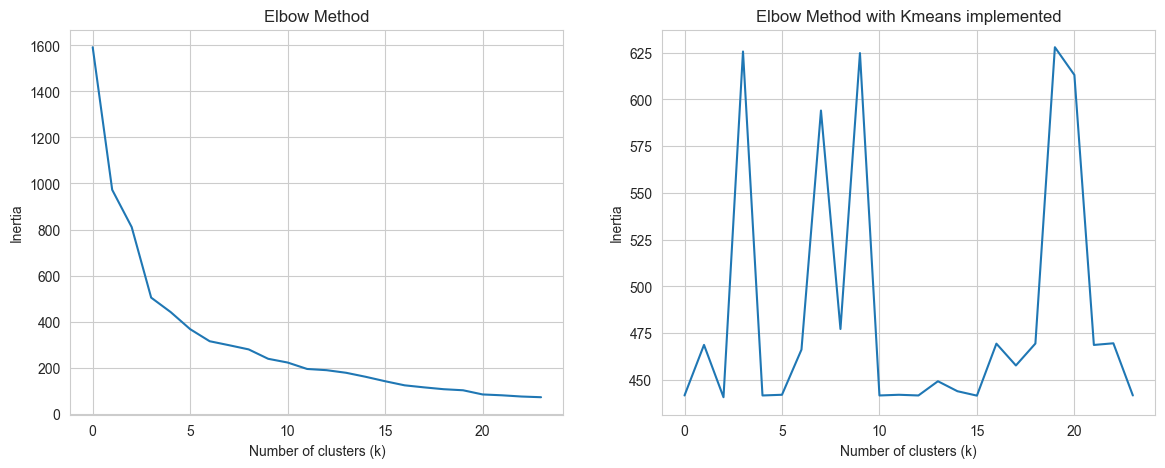

In [299]:
plt.subplots(1,2, figsize=(14,5))

# Plot the Elbow Curve
plt.subplot(1, 2, 1)
plt.plot(inertia)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot the Elbow Curve
plt.subplot(1, 2, 2)
plt.plot(inertia_mnist_impl)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with Kmeans implemented')
plt.show() 

**Remarque:**
- Le nombre de k optimal c'est 5 d'après le graphe ci-dessus, ce qui fait la moitié de k original qui est 10, en peut expliquer ça par que plusieur chartcher manuscrit s'écrit similaire prenant par exemple x et n ou a et o, etc.
- Le Kmean implémenté reste soufre de même problème d'initialisation.

## DBSCAN

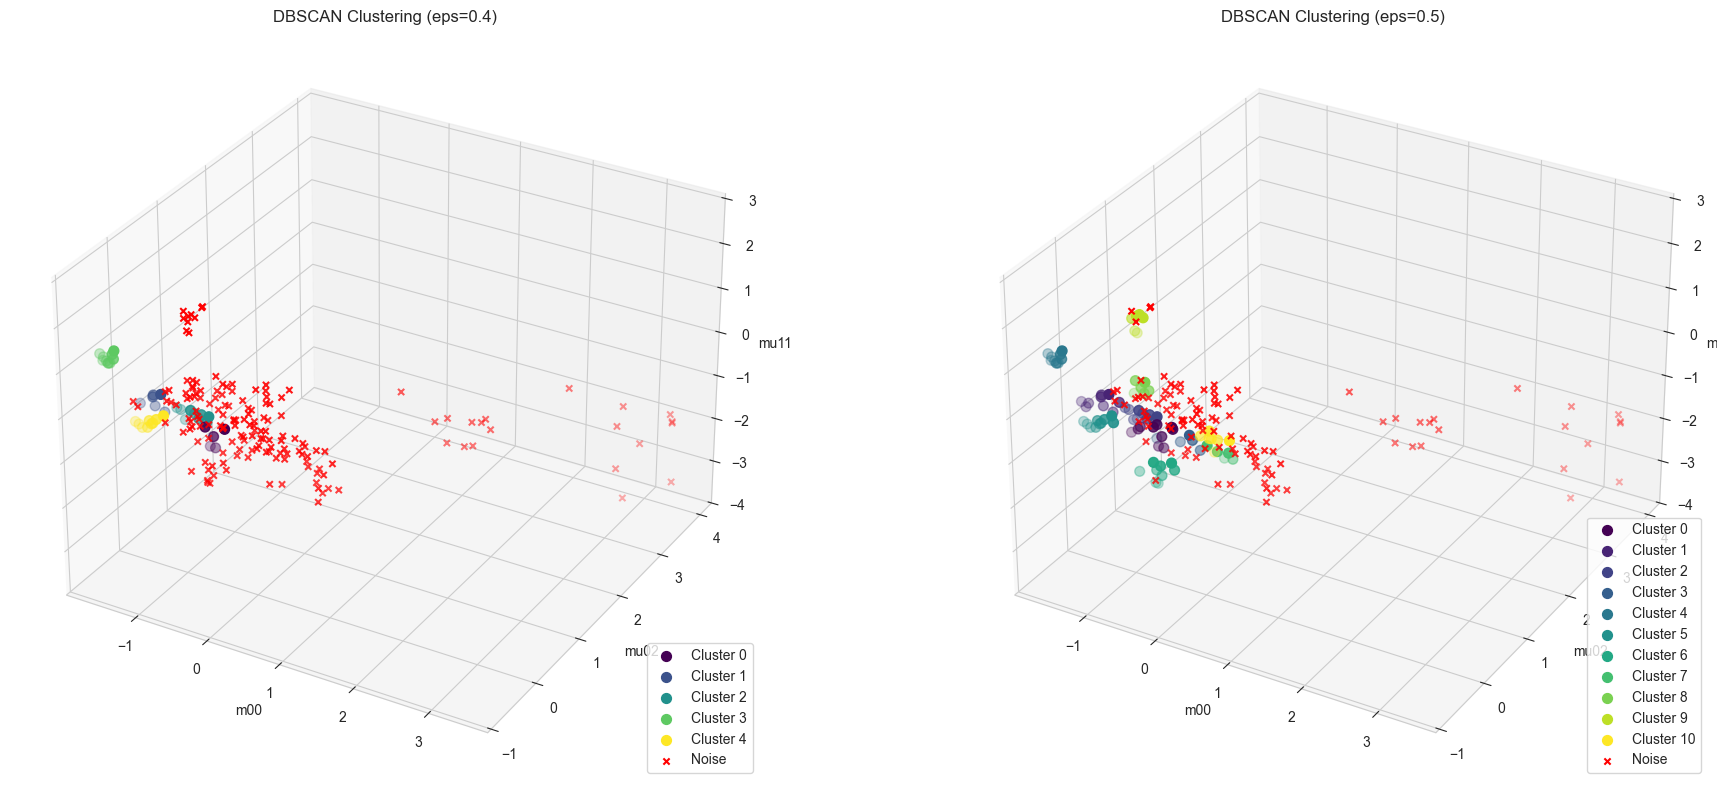

In [300]:
eps_values = [0.4, 0.5]

fig = plt.figure(figsize=(20, 8))
axes = [fig.add_subplot(1, len(eps_values), i + 1, projection='3d') for i in range(len(eps_values))]

for i, eps in enumerate(eps_values):
    dbscan_model = DBSCAN(eps=eps, min_samples=5, metric="euclidean")
    dbscan_model.fit(mnist_features)
    
    predictions_dbscan = dbscan_model.labels_
    unique_clusters = np.unique(predictions_dbscan)
    unique_clusters = unique_clusters[unique_clusters != -1]

    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
    
    ax = axes[i]
    for cluster, color in zip(unique_clusters, colors):
        cluster_points = predictions_dbscan == cluster
        ax.scatter(mnist_features['m00'][cluster_points], mnist_features['mu02'][cluster_points], mnist_features['mu11'][cluster_points],
                   color=color, label=f'Cluster {cluster}', s=50)
    
    noise = predictions_dbscan == -1
    ax.scatter(mnist_features['m00'][noise], mnist_features['mu02'][noise], mnist_features['mu11'][noise],
               color='red', label='Noise', marker='x')

    ax.set_title(f'DBSCAN Clustering (eps={eps})')
    ax.set_xlabel('m00')
    ax.set_ylabel('mu02')
    ax.set_zlabel('mu11')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

**Remarque:** Un petit changement sur le rayon de recherche (ε-voisinage) de 0.1, les résultats changent radicalement, la meme chose pour minPts.

Nous prenons ε = 0,5 et minPts = 5, car ce sont les seules valeurs de paramètres qui ont donné le nombre initial de clusters qui est de 10

In [301]:
indices = np.where(noise==True)

In [302]:
all_data.iloc[indices].head()

,classes,m00,mu02,mu11,mu20,mu03,mu12,mu21,mu30
14,c,107.0,1429.719626,138.766355,2676.971963,1552.374880,333.047602,2864.302909,1732.495414
30,m,189.0,9160.666667,-131.222222,4300.550265,632.814815,-6739.197531,750.635509,-4673.188657
31,m,214.0,10967.439252,-570.224299,4982.210280,-3070.315661,-6539.034676,-78.234431,-3727.020875
32,m,218.0,11003.197248,-380.568807,4809.779817,-934.388014,-5822.159078,1278.307466,-3648.395926
33,m,223.0,11456.753363,-373.937220,5089.838565,1195.370026,-5873.412737,574.714110,-4064.843331


In [303]:
all_data.select_dtypes(include='number').median()

m00      136.000000
mu02    1958.393534
mu11     -18.732785
mu20    3342.125218
mu03     228.158244
mu12    -644.649676
mu21     148.207111
mu30    -303.657105
dtype: float64

**Remarque:** En comparant les différentes valeurs des points considérés comme bruit et la médiane, on constate que ces points sont trop éloignés, ce qui justifie cette attribution.